Homework is creating a multimodal similarity search service. It will retrieve images based on a text query, using embeddings from a multimodal model.
# Dataset preparation (1 point)
1. Download the dataset: [Amazon Berkeley Objects Dataset](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar)
2. Unpack the dataset and locate the metadata file images.csv.gz in images/metadata/
3. Extract the image paths from the dataset:
    - write a Python script that extracts valid image paths from the CSV file
    - keep only images with at least 1000 pixels of width and height
    - you can use Pandas, Polars etc. as you wish, add with uv whatever is necessary

In [1]:
import os
import polars as pl

image_paths = (
    pl.scan_csv("images/metadata/images.csv.gz")
    .filter((pl.col("height") >= 1000) & (pl.col("width") >= 1000))
    .with_columns(
        path= "images/small/" + pl.col("path")
    )
    .drop("image_id", "height", "width")
    .collect()
    .to_series()
)
image_paths

path
str
"""images/small/46/4689906d.png"""
"""images/small/0c/0cd7596c.jpg"""
"""images/small/e6/e602a9af.jpg"""
"""images/small/e7/e7cfeb02.jpg"""
"""images/small/68/6839db4e.jpg"""
…
"""images/small/6d/6d49d130.jpg"""
"""images/small/b1/b163e0ea.jpg"""
"""images/small/a1/a116d9d1.jpg"""


# Model Selection and Understanding (1 point)
1. Read the [CLIP Image Search Tutorial.](https://www.sbert.net/examples/applications/image-search/README.html)
2. Search for clip-ViT-B-32 model from sentence-transformers on HuggingFace Hub.
3. Determine the vector length (size) produced by the model, and what type of model is it.

Questions:
- What is the vector size produced by clip-ViT-B-32?
    - 512
- What do ViT, B and 32 mean in the model name?
    - vit - vision transformer
    - B - Base (i.e base model is smaller than a Large model)
    - 32 - using 32x32 patches

# Database setup (2 points)
1. Set up Postgres database with pgvectorscale extension. You can reuse the database from the lab.
2. Use SQLAlchemy to connect to it with create_engine and URL.
3. Create a database table definition for storing image embeddings. Complete the following SQLAlchemy model:


In [2]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, text

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5556,
    database="similarity_search_service_db",
)

engine = create_engine(db_url)

with engine.connect() as conn:
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS vector;"))
    conn.commit()



In [3]:
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from pgvector.sqlalchemy import Vector
from sqlalchemy import String
from typing import List

class Base(DeclarativeBase):
    __abstract__ = True

class Img(Base):
    __tablename__ = "images_hw"
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH: int = 512 # implement me!
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256)) # implement me!
    embedding: Mapped[List[float]] =  mapped_column(Vector(VECTOR_LENGTH)) # implement me!

# for later
class Img50k(Base):
    __tablename__ = "images_50k"
    __table_args__ = {'extend_existing': True}

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[list[float]] = mapped_column(Vector(512))

class Img100k(Base):
    __tablename__ = "images_100k"
    __table_args__ = {'extend_existing': True}

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(256))
    embedding: Mapped[list[float]] = mapped_column(Vector(512))
###     
# Create table
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

In [4]:
from sqlalchemy import inspect

inspector = inspect(engine)
tables = inspector.get_table_names()
print("Tables in database:", tables)

Tables in database: ['images', 'games', 'images_hw', 'images_50k', 'images_100k']


# Image vectorization (3 points)

Fill the code below that performs image vectorization, i.e. calculates an embedding for each image. Model input is an image, its output is a vector (embedding).

Notes:
1. Adjust MAX_IMAGES, the number of images processed, based on your computational capabilities. The more images you process, the more accureate results of search you will get. If you have a GPU, you can use it and process more images.
2. Load the CLIP model with sentence-transformers. It is a nice, high-level framework, based on PyTorch. To enable GPU usage, the following code is useful:
`device = "cuda" if torch.cuda.is_available() else "cpu" `

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


3. Implement batching for efficiency, as embedding a single image at a time is very inefficient. In that case, you would spend most of the time sending data between RAM and CPU/GPU, instead of actually doing the work. Working in batches optimizes this transfer time. Similarly, batching is more efficient for databases, as it lowers the overhead for managing transactions.
4. Implement all necessary code parts:
    - iterate through image paths
    - implement batching
    - insert batch of images into the database
    - update progress bar pgar with appropriate batch size


In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32", device=device)
print(model.device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


cuda:0


In [7]:
import joblib
import torch
import time
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from itertools import batched
from sqlalchemy.orm import Session
from concurrent.futures import ThreadPoolExecutor

#MAX_IMAGES = 342_878# Adjust it for your needs
#BATCH_SIZE = 1024#4*joblib.cpu_count(only_physical_cores=True)

def load_image(path):
    return Image.open(path)

def load_images_parallel(paths, max_workers=32):
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        return list(filter(None, ex.map(load_image, paths)))

def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()

def vectorize_images(engine, model, image_paths, ImgClass, max_images, batch_size = 1024):
    image_paths = image_paths[:max_images]
    with tqdm(total=max_images) as pbar:
        for images_paths_batch in batched(image_paths, batch_size):  # finish (suggestion - use `batched`)
            #images = [Image.open(path) for path in images_paths_batch]
            images = load_images_parallel(images_paths_batch)

            embeddings = model.encode(images)
            
            # create Img instances for all images in batch
            images = [ImgClass(image_path=img_path, embedding=embed) for img_path, embed in zip(images_paths_batch, embeddings)]
            
            # insert all batch images
            insert_images(engine, images)
            
            # update pbar
            pbar.update(len(images))

In [8]:
vectorize_images(engine, model, image_paths, Img, max_images = 342_878)

  0%|          | 0/342878 [00:00<?, ?it/s]

# Search and results display (3 points)

Fill the code below that searches for the most similar embeddings based on a text description. After that:

1. Check a few different queries. Are results relevant?


In [9]:
import matplotlib.pyplot as plt
from sqlalchemy import select
from sqlalchemy.orm import Session
from PIL import Image


class ImageSearch:
    def __init__(self, engine, model, ImgClass):
        self.engine = engine
        self.model = model
        self.ImgClass = ImgClass

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images([img.image_path for img in found_images], k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description)

        with Session(self.engine) as session:
            query = select(self.ImgClass).order_by(self.ImgClass.embedding.cosine_distance(image_embedding)).limit(k)
            result = session.execute(query, execution_options={"prebuffer_rows": True})

        return result.scalars().all()

    def display_images(self, images, k: int):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            print(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

images/small/34/34000b53.jpg
images/small/8f/8fbdc8d3.jpg
images/small/be/befa7c6a.jpg
images/small/5f/5fc7d1c2.jpg
images/small/90/90a6bdc2.jpg


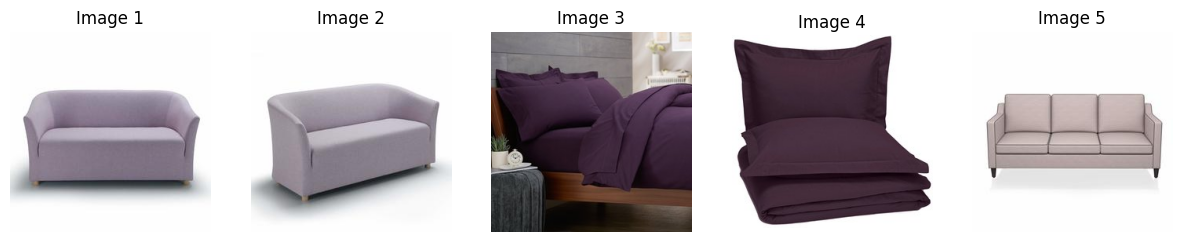

images/small/5a/5a764662.jpg
images/small/87/87b78e14.jpg
images/small/d8/d8e5af46.jpg
images/small/fb/fb2ff237.jpg
images/small/5b/5b395a07.jpg


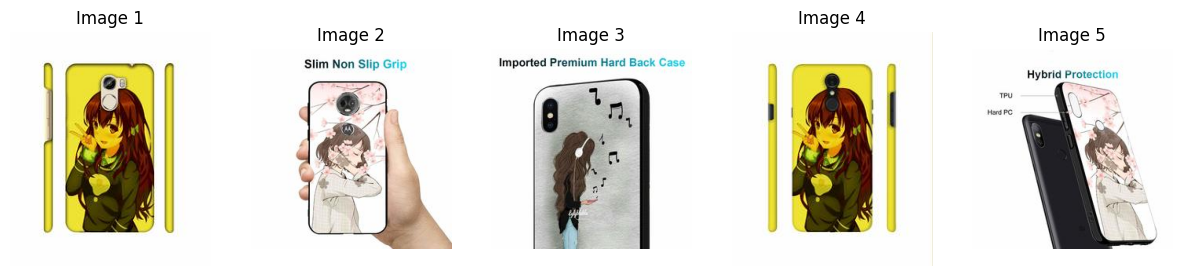

images/small/d9/d9f171d3.jpg
images/small/da/da308820.jpg
images/small/d5/d53f077b.jpg
images/small/8f/8f412171.jpg
images/small/c4/c47f17ca.jpg


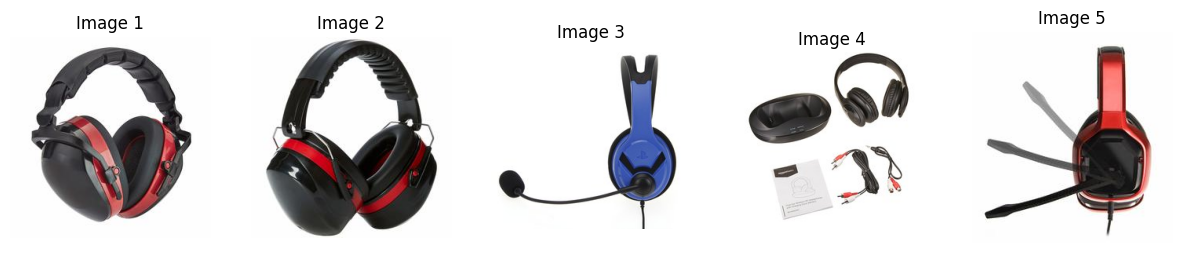

images/small/30/307a7d1d.jpg
images/small/35/35eca650.jpg
images/small/29/2935c40a.jpg
images/small/67/675d9ade.jpg
images/small/41/41255cd8.jpg


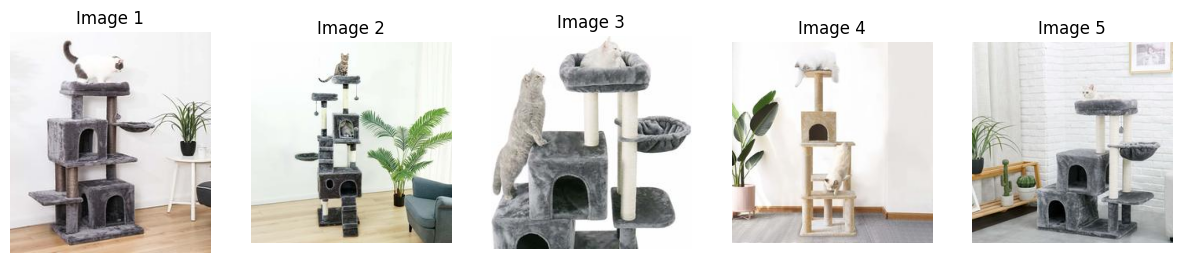

In [28]:
ImageSearch(engine, model, Img)("purple sofa", k=5)
ImageSearch(engine, model, Img)("phone case", k=5)
ImageSearch(engine, model, Img)("gaming headphones", k=5)
ImageSearch(engine, model, Img)("cat tree", k=5)

2. Check 3 different MAX_IMAGES sizes. Do you see more accurate results for larger datasets?

In [12]:
vectorize_images(engine, model, image_paths, Img100k, max_images = 100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

images/small/34/34000b53.jpg
images/small/8f/8fbdc8d3.jpg
images/small/a9/a99a52f9.jpg
images/small/72/729839aa.jpg
images/small/b5/b59ce6df.jpg


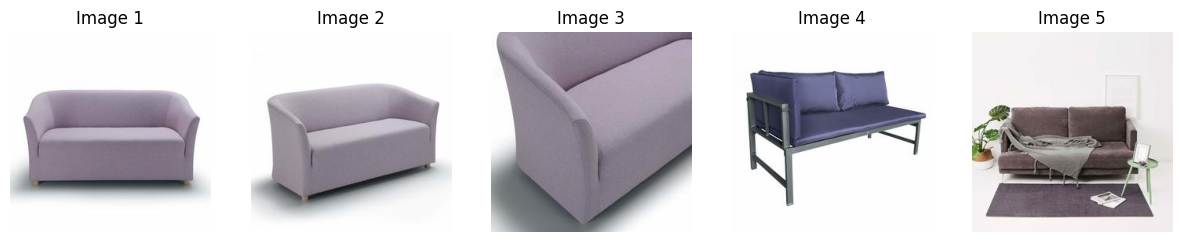

images/small/5a/5a764662.jpg
images/small/87/87b78e14.jpg
images/small/d8/d8e5af46.jpg
images/small/fb/fb2ff237.jpg
images/small/5b/5b395a07.jpg


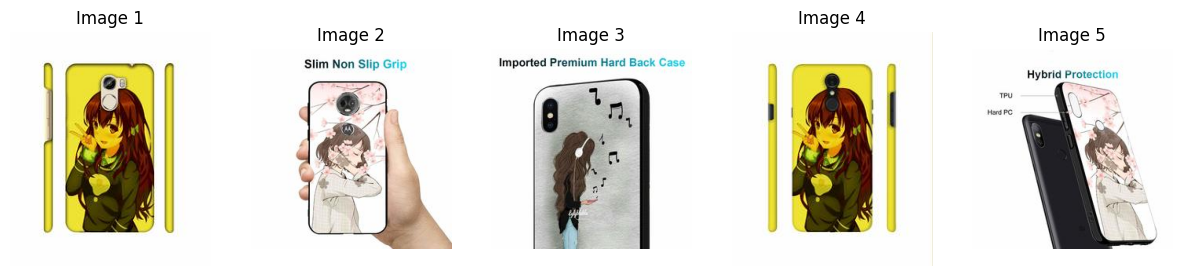

images/small/d5/d53f077b.jpg
images/small/94/94188096.jpg
images/small/74/7450011b.jpg
images/small/8e/8eafed8a.jpg
images/small/0b/0bf1af6e.jpg


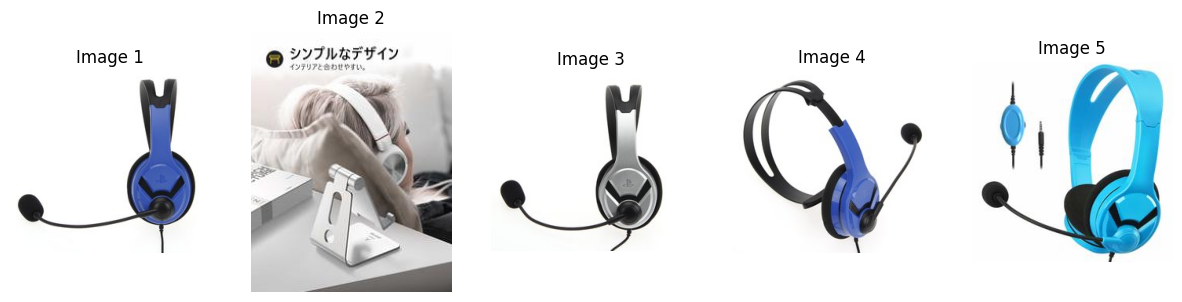

images/small/30/307a7d1d.jpg
images/small/67/675d9ade.jpg
images/small/cf/cfd68a6b.jpg
images/small/51/514aa198.jpg
images/small/d8/d8fc5ab5.jpg


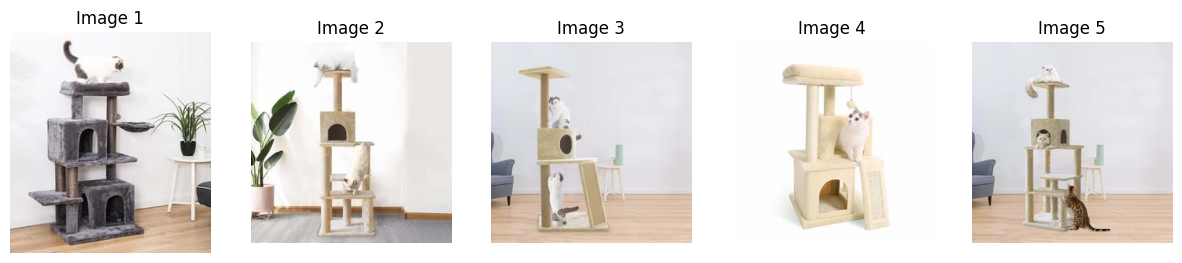

In [29]:
ImageSearch(engine, model, Img100k)("purple sofa", k=5)
ImageSearch(engine, model, Img100k)("phone case", k=5)
ImageSearch(engine, model, Img100k)("gaming headphones", k=5)
ImageSearch(engine, model, Img100k)("cat tree", k=5)

In [22]:
vectorize_images(engine, model, image_paths, Img50k, max_images = 50_000)

images/small/34/34000b53.jpg
images/small/8f/8fbdc8d3.jpg
images/small/72/729839aa.jpg
images/small/ba/ba175e88.jpg
images/small/a9/a99a52f9.jpg


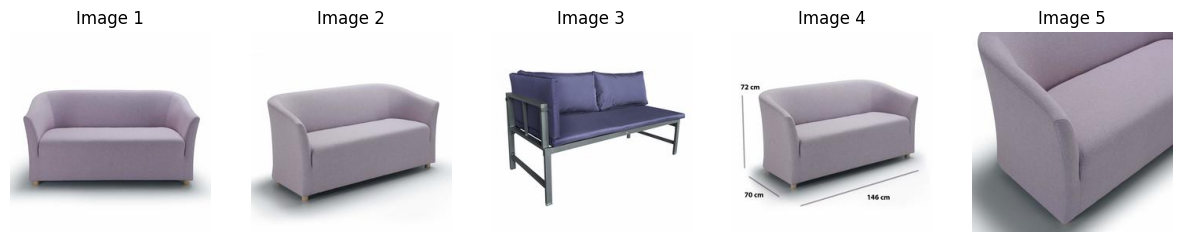

images/small/87/87b78e14.jpg
images/small/2a/2ac36e25.jpg
images/small/b8/b81a988a.jpg
images/small/9f/9f476674.jpg
images/small/6c/6cbebad7.jpg


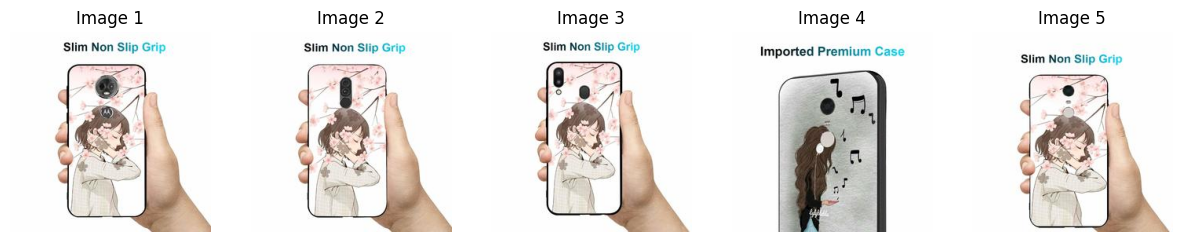

images/small/94/94188096.jpg
images/small/8e/8eafed8a.jpg
images/small/ee/ee6406df.jpg
images/small/07/07a75d99.jpg
images/small/4c/4c65bf0d.jpg


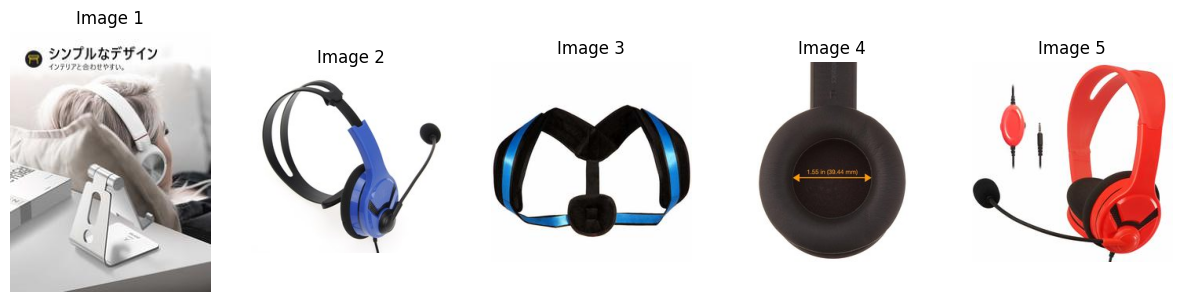

images/small/c3/c322d0ec.jpg
images/small/9d/9df034aa.jpg
images/small/62/623e44c9.jpg
images/small/d5/d5ca40f2.jpg
images/small/81/81c7beff.jpg


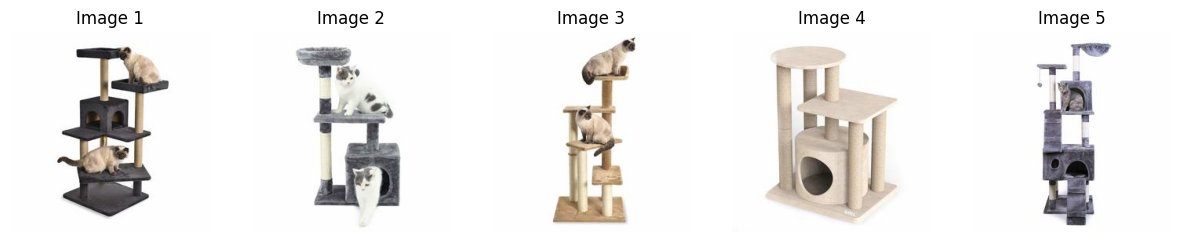

In [30]:
search50k = ImageSearch(engine, model, Img50k)
ImageSearch(engine, model, Img50k)("fancy purple sofa", k=5)
ImageSearch(engine, model, Img50k)("phone case", k=5)
ImageSearch(engine, model, Img50k)("gaming headphones", k=5)
ImageSearch(engine, model, Img50k)("cat tree", k=5)